In [1]:
import csv
import re
import os
import numpy as np
import pandas as pd
from skimage import io
import cv2
import skimage.io
from matplotlib import pyplot as plt
from skimage.filters import threshold_li
from skimage.morphology import remove_small_holes, remove_small_objects, label
from skimage.measure import regionprops, regionprops_table

In [2]:
def render(path, threshold=70, size=400):
    '''Function which returns one uneditted "green" channel and one after rendering - 
    first threshold of intensity is given, than objects which are smaller than "size" are 
    not included as well'''
    img = cv2.imread(path)
    blue, green, red = cv2.split(img)
    img2 = green > threshold
    img2 = remove_small_objects(img2, min_size=size)
    return green, img2

In [3]:
#two examples to show in mehtods how the quantification works
img, img2 = render('03-Images/tiff_files/cortex_tiffs/cre+_virGA_MAX_33658 1 40x HA555 GA488 cortex ns.czi (RGB).tif')
img3, img4 = render('03-Images/tiff_files/cortex_tiffs/cre-_virGA_MAX_33658 3 40x HA555 GA488 cortex ns.czi (RGB).tif')

In [4]:
one, one_2 = render('03-Images/tiff_files/hippo_tiffs/cre+_virPR_MAX_33815 6 hippo.czi (RGB).tif')
two, two_2 = render('03-Images/tiff_files/spine_tiffs/cre+_virGA_MAX_35861 3.czi (RGB).tif')

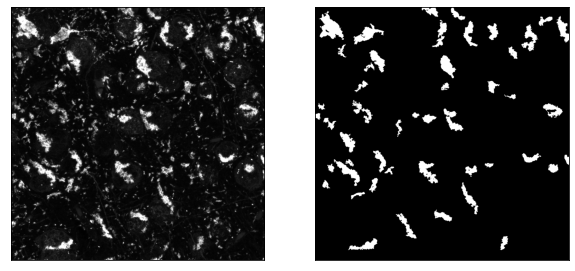

In [5]:
#for methods to show how the qunatification works
f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(img, cmap='gray')
ax[0].set_xticks([])  # remove the x-axis ticks
ax[0].set_yticks([])  # remove the y-axis ticks

ax[1].imshow(img2, cmap='gray')
ax[1].set_xticks([])  # remove the x-axis ticks
ax[1].set_yticks([])  # remove the y-axis ticks
plt.savefig('methods_quantification_aggregates.png')

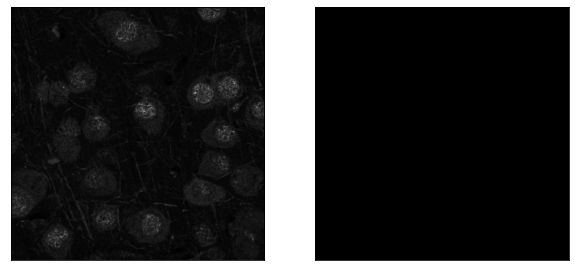

In [6]:
#for methods
# f = plt.figure()
# f.add_subplot(1,2, 1)
# plt.imshow(img3, cmap='gray')
# f.add_subplot(1,2, 2)
# plt.imshow(img4, cmap='gray')

f, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].imshow(img3, cmap='gray')
ax[0].set_xticks([])  # remove the x-axis ticks
ax[0].set_yticks([])  # remove the y-axis ticks

ax[1].imshow(img4, cmap='gray')
ax[1].set_xticks([])  # remove the x-axis ticks
ax[1].set_yticks([])  # remove the y-axis ticks
plt.savefig('methods_quantification_no_aggregates.png')

In [7]:
def analyze_image(path):
    """from image file, labels image and returns a list of: aggregate count and total area of aggreagates"""
    labelled = label(render(path)[1])
    count = np.max(labelled)
    df = pd.DataFrame.from_dict(regionprops_table(labelled, properties=['area']))
    total_area = df['area'].sum()
    return [count, total_area]

In [8]:
def analyze_folder(folder):
    '''Takes in folder with images and returns a pandas Dataframe with filename, aggregate count,
     and total area of aggreagates'''
    files = os.listdir(folder)
    failed_files = []
    df = pd.DataFrame(columns=['Name', 'Count', 'Area'])
    for f in files:
        try:
            if f == '.DS_Store':
                continue
            filepath = folder + '/'+f
            analyzed_img = analyze_image(filepath)
            d = pd.DataFrame.from_dict({'Name': [f], 'Count': [analyzed_img[0]], 'Area': [analyzed_img[1]]})
            df = pd.concat([df,d], ignore_index=True)
        except ValueError:
            failed_files.append(f)

    if failed_files == True:
        print('failed files:')
        for a in failed_files:
            print(f)
    return df

In [9]:
def quantification(folder):
    '''takes in a complete folder containing folders of different experimental groups and
    makes one dataframe from it, and saves it to excel'''
    subfolders = os.listdir(folder)
    l = []
    for sf in subfolders:
        if sf == '.DS_Store':
            continue
        folderpath = folder+'/'+sf
        df = analyze_folder(folderpath)
        l.append(df)
    complete_df = pd.concat(l, ignore_index=True)
    name = 'quantification'+ '.csv'
    complete_df.to_csv(name,sep = ';', index=False)

In [10]:
#do the quantification to the folder I want
quantification("03-Images/tiff_files")

In [11]:
#collect data into 6 lists for plotting
#first seperate the different nervous tissue
cortex = []
hippo = []
spine = []

#then sepparate the sick from healthy
cortex_sick = []
hippo_sick = []
spine_sick = []

cortex_antiGA_count = []
cortex_antiPR_count = []
hippo_antiGA_count = []
hippo_antiPR_count = []
spine_antiGA_count = []
spine_antiPR_count = []

cortex_antiGA_area = []
cortex_antiPR_area = []
hippo_antiGA_area = []
hippo_antiPR_area = []
spine_antiGA_area = []
spine_antiPR_area = []

def seperate_name(name):
    seperated_name = name.split('_')
    return seperated_name

def has_word(s, word):
  # Use a regular expression to check for the word 
  return bool(re.search(rf'{word}', s))

# Open the CSV file
with open('quantification.csv', 'r') as file:
  # Create a CSV reader object
  reader = csv.reader(file, delimiter=';')
  
  # Iterate over the rows of the CSV file
  for row in reader:
    #sepereate tissues
    if has_word(row[0], 'hippo'):
        hippo.append(row)
    elif has_word(row[0], 'cortex'):
        cortex.append(row)
    elif row == ['Name', 'Count', 'Area']:
        continue
    else:
        spine.append(row)

for c in cortex:
    if has_word(c[0],'\+'):
        cortex_sick.append(c)
        
for h in hippo:
    if has_word(h[0], '\+'):
        hippo_sick.append(h)

for s in spine:
    if has_word(s[0], '\+'):
        spine_sick.append(s)

for x in (cortex_sick, hippo_sick, spine_sick):
    for y in x:
        print(y)
    print('\n')

#seperate vir GA from PR
for cs in cortex_sick:
    if has_word(cs[0], 'virGA'):
        cortex_antiGA_count.append(int(cs[1]))
        cortex_antiGA_area.append(int(cs[2]))
    elif has_word(cs[0], 'virPR'):
        cortex_antiPR_count.append(int(cs[1]))
        cortex_antiPR_area.append(int(cs[2]))
        print(cs[0])

for hs in hippo_sick:
    if has_word(hs[0], 'virGA'):
        hippo_antiGA_count.append(int(hs[1]))
        hippo_antiGA_area.append(int(hs[2]))
    elif has_word(hs[0], 'virPR'):
        hippo_antiPR_count.append(int(hs[1]))
        hippo_antiPR_area.append(int(hs[2]))    

for ss in spine_sick:
    if has_word(ss[0], 'virGA'):
        spine_antiGA_count.append(int(ss[1]))
        spine_antiGA_area.append(int(ss[2]))
    elif has_word(ss[0], 'virPR'):
        spine_antiPR_count.append(int(ss[1]))
        spine_antiPR_area.append(int(ss[2]))

print(spine_antiGA_area)
print(spine_antiPR_area)

['cre+_virGA_MAX_34738 4 40x HA555 GA488 cortex ns.czi (RGB).tif', '64', '70518']
['cre+_virPR_MAX_33815 4 40x HA555 GA488 cortex ns.czi (RGB).tif', '51', '49527']
['cre+_virGA_MAX_35861 3 40x HA555 GA488 cortex ns.czi (RGB).tif', '67', '77705']
['cre+_virGA_MAX_33658 1 40x HA555 GA488 cortex ns.czi (RGB).tif', '49', '74008']
['cre+_virPR_MAX_33815 6 40x HA555 GA488 cortex ns.czi (RGB).tif', '47', '75648']
['cre+_virGA_MAX_34738 3 40x HA555 GA488 cortex ns.czi (RGB).tif', '50', '58583']
['cre+_virGA_MAX_33658 2 40x HA555 GA488 cortex ns.czi (RGB).tif', '43', '41558']
['cre+_virPR_MAX_34738 9 40x HA555 GA488 cortex ns.czi (RGB).tif', '38', '35518']
['cre+_virPR_MAX_34738 8 40x HA555 GA488 cortex ns.czi (RGB).tif', '63', '59421']


['cre+_virPR_MAX_35861 5 hippo.czi (RGB).tif', '73', '134801']
['cre+_virGA_MAX_35861 3 hippo.czi (RGB).tif', '58', '131486']
['cre+_virPR_MAX_33815 6 hippo.czi (RGB).tif', '82', '170620']
['cre+_virPR_MAX_33815 4 hippo.czi (RGB).tif', '54', '140286']
['cre+_v

In [12]:
def make_line(significance=False):
    '''draws line to a graph where you want it'''
    # Calculate the x-coordinates for the start and end points of the line
    line_start_x = positions - 0.125  # x-coordinate for the "Sick-Not treated" group
    line_end_x = x_pos[2] + 0.125  # x-coordinate for the "Sick-Treated" group

    # Calculate the y-coordinates for the start and end points of the line
    line_start_y = females_sick_untreated_mean + 2  # Add 0.1 as a buffer above the bar for the "Sick-Not treated" group
    line_end_y = females_sick_untreated_mean + 2  # Add 0.1 as a buffer above the bar for the "Sick-Treated" group

    # Calculate the y-coordinate for the text
    text_y = (line_start_y + line_end_y) / 2  # Position the text halfway between the start and end points of the line

    # Plot the line
    ax.plot([line_start_x, line_end_x], [line_start_y, line_end_y], color='black', linestyle='dotted', linewidth=2)

    # Add the text
    ax.text((line_start_x + line_end_x) / 2, text_y, 'n. s.', ha='center', va='bottom', fontsize=12)

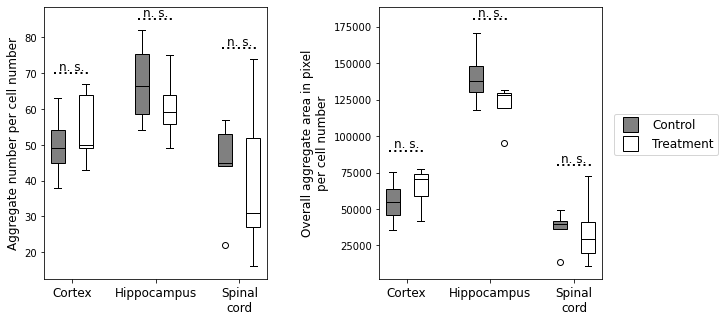

In [13]:
#make a plot
from matplotlib.lines import Line2D

# Define the data for the count boxplot
all_count = [cortex_antiPR_count, cortex_antiGA_count, hippo_antiPR_count, 
             hippo_antiGA_count, spine_antiPR_count,spine_antiGA_count]
# Define the data for the area boxplot
all_area = [cortex_antiPR_area, cortex_antiGA_area, hippo_antiPR_area, 
            hippo_antiGA_area, spine_antiPR_area, spine_antiGA_area]

positions = [1, 2, 4, 5, 7, 8]
x_ticks = [1.5,4.5,7.5]
labels = ['Cortex', 'Hippocampus', 'Spinal\ncord']
colors = ['grey', 'white', 'grey', 'white', 'grey', 'white']

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Create the count boxplot
bp1 = ax1.boxplot(all_count, positions=positions, medianprops={'color':'black'}, patch_artist=True)

# Create the area boxplot
bp2 = ax2.boxplot(all_area, positions=positions, medianprops={'color':'black'}, patch_artist=True)


ax1.set_xticks(x_ticks)
ax2.set_xticks(x_ticks)
ax1.set_xticklabels(labels, fontsize=12)
ax2.set_xticklabels(labels, fontsize=12)
ax1.set_ylabel('Aggregate number per cell number', fontsize= 12)
ax2.set_ylabel("Overall aggregate area in pixel\nper cell number", fontsize=12)

plt.subplots_adjust(wspace=0.5)

for bplot in (bp1, bp2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

#legend
treatment_boxes = Line2D([], [], marker='s', color='w', label='Treatment', markerfacecolor='white',markeredgecolor='black', markersize=10, fillstyle='full')
control_boxes = Line2D([], [], marker='s', color='w', label='Control', markerfacecolor='grey',markeredgecolor='black', markersize=10, fillstyle='full')
fig.legend(handles=[control_boxes, treatment_boxes], bbox_to_anchor= (1.07,0.6), fontsize=12, markerscale=1.5)


def make_line(axis, position1, position2, height, significance = 'n. s.'):
    
    #lines
    # Calculate the x-coordinates for the start and end points of the line
    line_start_x = position1 - 0.125  # x-coordinate for the "Sick-Not treated" group
    line_end_x = position2 + 0.125  # x-coordinate for the "Sick-Treated" group

    # Calculate the y-coordinates for the start and end points of the line
    line_start_y = height  # Add 0.1 as a buffer above the bar for the "Sick-Not treated" group
    line_end_y = height  # Add 0.1 as a buffer above the bar for the "Sick-Treated" group

    # Calculate the y-coordinate for the text
    text_y = (line_start_y + line_end_y) / 2  # Position the text halfway between the start and end points of the line

    # Plot the line
    axis.plot([line_start_x, line_end_x], [line_start_y, line_end_y], color='black', linestyle='dotted', linewidth=2)

    # Add the text
    axis.text((line_start_x + line_end_x) / 2, text_y, significance, ha='center', va='bottom', fontsize=12)

make_line(ax1, positions[0], positions[1], 70)
make_line(ax1, positions[2], positions[3], 85)
make_line(ax1, positions[4], positions[5], 77)
make_line(ax2, positions[0], positions[1], 90000)
make_line(ax2, positions[2], positions[3], 180000)
make_line(ax2, positions[4], positions[5], 80000)

#savefig
plt.savefig("Quantification.png", bbox_inches="tight")
# Show the plot
plt.show()

In [14]:
#run t-test
def significance_test(test, niveau = 0.05):
    if test.pvalue < niveau:
        print("T Test significant. Null hypothesis can be rejected")
    elif test.pvalue >= niveau:
        print("T Test not significant. Null hypothesis cannot be rejected.")


spine_antiGA_area = []
spine_antiPR_area = []
from scipy import stats
#t-test for aggregates
print("T-tests for aggregates count!")
print('\n')
print("T-Test cortex:")
t_test_cortex = stats.ttest_ind(cortex_antiPR_count, cortex_antiGA_count)
print(t_test_cortex)
print(f'n untreated = {len(cortex_antiGA_count)}\nn treated={len(cortex_antiGA_count)}')
significance_test(t_test_cortex)
print('\n')
print("T-Test hippo:")
t_test_hippo = stats.ttest_ind(hippo_antiPR_count, hippo_antiGA_count)
print(t_test_hippo)
print(f'n untreated = {len(hippo_antiPR_count)}\nn treated={len(hippo_antiGA_count)}')
significance_test(t_test_hippo)
print('\n')
print("T-Test spine:")
t_test_spine = stats.ttest_ind(spine_antiPR_count, spine_antiGA_count)
print(t_test_spine)
print(f'n untreated = {len(spine_antiPR_count)}\nn treated={len(spine_antiGA_count)}')
significance_test(t_test_spine)

#t-tests for aggregates area
print("\n")
print("t_tests for aggreagates area")
print('\n')
print("T-Test cortex:")
t_test_cortex = stats.ttest_ind(cortex_antiPR_area, cortex_antiGA_area)
print(t_test_cortex)
print(f'n untreated = {len(cortex_antiPR_area)}\nn treated={len(cortex_antiGA_area)}')
significance_test(t_test_cortex)
print('\n')
print("T-Test hippo:")
t_test_hippo = stats.ttest_ind(hippo_antiPR_area, hippo_antiGA_area)
print(t_test_hippo)
print(f'n untreated = {len(hippo_antiPR_area)}\nn treated={len(hippo_antiGA_area)}')
significance_test(t_test_hippo)
print('\n')
print("T-Test spine:")
spine_antiGA_area = [72376, 10617, 29463, 40984, 19619]
spine_antiPR_area = [36592, 13766, 39618, 49061, 41591]
t_test_spine = stats.ttest_ind(spine_antiPR_area, spine_antiGA_area)
print(t_test_spine)
print(f'n untreated = {len(spine_antiPR_area)}\nn treated={len(spine_antiGA_area)}')
significance_test(t_test_spine)

T-tests for aggregates count!


T-Test cortex:
Ttest_indResult(statistic=-0.6975735738670041, pvalue=0.5079441667376962)
n untreated = 5
n treated=5
T Test not significant. Null hypothesis cannot be rejected.


T-Test hippo:
Ttest_indResult(statistic=0.8127272119171581, pvalue=0.44741423933904767)
n untreated = 4
n treated=4
T Test not significant. Null hypothesis cannot be rejected.


T-Test spine:
Ttest_indResult(statistic=0.35117253259759207, pvalue=0.7345279338327841)
n untreated = 5
n treated=5
T Test not significant. Null hypothesis cannot be rejected.


t_tests for aggreagates area


T-Test cortex:
Ttest_indResult(statistic=-0.8988976747701493, pvalue=0.3985715428429536)
n untreated = 4
n treated=5
T Test not significant. Null hypothesis cannot be rejected.


T-Test hippo:
Ttest_indResult(statistic=1.4500918063789756, pvalue=0.19721769380148282)
n untreated = 4
n treated=4
T Test not significant. Null hypothesis cannot be rejected.


T-Test spine:
Ttest_indResult(statistic=0.123